#  <center> Speech Emotion Recognition <center>

### I am going to build a speech emotion detection classifier.
### But first we need to learn about what is speech recognition (SER) and why are we building this project? Well, few of the reasons are-

#### First, lets define SER i.e. Speech Emotion Recognition.
* Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

#### Why we need it?

1. Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

2. SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

3. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Toronto emotional speech set (Tess)

# Importing Libraries

In [93]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import itertools
import glob


## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [1]:
# Paths for data.
Ravdess = "ravdess_dataset"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"



In [3]:
os.environ['KAGGLE_USERNAME'] = 'kashishdeepkaur'
os.environ['KAGGLE_KEY'] = '5a5d2222da96ba4bd7d7bd659c3e6e5e'


In [47]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

#  Initialize and authenticate Kaggle API
api = KaggleApi()
api.authenticate()

#  Define dataset names
tess_dataset = "ejlok1/toronto-emotional-speech-set-tess"
ravdess_dataset = "uwrfkaggler/ravdess-emotional-speech-audio"
cremad_dataset = "ejlok1/cremad"  # Fixed variable name (no hyphen)

# Define separate download paths
tess_download_path = "tess_dataset"
ravdess_download_path = "ravdess_dataset"
cremad_download_path = "cremad_dataset"  # Added CREMA-D download path

# Ensure the directories exist
os.makedirs(tess_download_path, exist_ok=True)
os.makedirs(ravdess_download_path, exist_ok=True)
os.makedirs(cremad_download_path, exist_ok=True)  # Ensure CREMA-D directory exists

#  Download and extract the TESS dataset
api.dataset_download_files(tess_dataset, path=tess_download_path, unzip=True)
print(" TESS dataset downloaded and extracted successfully!")

# Download and extract the RAVDESS dataset
api.dataset_download_files(ravdess_dataset, path=ravdess_download_path, unzip=True)
print("RAVDESS dataset downloaded and extracted successfully!")

#  Download and extract the CREMA-D dataset
api.dataset_download_files(cremad_dataset, path=cremad_download_path, unzip=True)
print(" CREMA-D dataset downloaded and extracted successfully!")


Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
 TESS dataset downloaded and extracted successfully!
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
RAVDESS dataset downloaded and extracted successfully!
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
 CREMA-D dataset downloaded and extracted successfully!


##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [48]:
# Define the correct path to the Ravdess dataset
Ravdess = "ravdess_dataset"  # Update this path with the actual location


ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # Construct the full directory path
    actor_dir = os.path.join(Ravdess, dir)
    
    # Ensure it's actually a directory before listing files
    if os.path.isdir(actor_dir):
        actor_files = os.listdir(actor_dir)
        for file in actor_files:
            part = file.split('.')[0].split('-')
            if len(part) > 2:  # Ensure we have the correct file format
                file_emotion.append(int(part[2]))
                file_path.append(os.path.join(actor_dir, file))

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


,Emotions,Path
0,neutral,ravdess_dataset\Actor_01\03-01-01-01-01-01-01.wav
1,neutral,ravdess_dataset\Actor_01\03-01-01-01-01-02-01.wav
2,neutral,ravdess_dataset\Actor_01\03-01-01-01-02-01-01.wav
3,neutral,ravdess_dataset\Actor_01\03-01-01-01-02-02-01.wav
4,calm,ravdess_dataset\Actor_01\03-01-02-01-01-01-01.wav


##  <center> 2. TESS dataset <center>

In [85]:
# Define the dataset directory
tess_dataset = "tess_dataset/TESS Toronto emotional speech set data/"

# List all directories in TESS dataset
tess_dataset_directory_list = os.listdir(tess_dataset)

file_emotion = []
file_path = []

# Iterate through each folder and collect file paths & emotions
for dir in tess_dataset_directory_list:
    dir_path = os.path.join(tess_dataset, dir)  # Correctly form directory path

    if os.path.isdir(dir_path):  # Ensure it's a folder
        files = os.listdir(dir_path)

        for file in files:
            if file.endswith('.wav'):  # Process only .wav files
                file_name = os.path.basename(file)
                
                # Extract the emotion label (last part of filename before ".wav")
                emotion = file_name.split('_')[-1].replace('.wav', '')

                # Rename 'ps' to 'surprise' (as per dataset convention)
                if emotion == 'ps':
                    emotion = 'surprise'

                # Store file path and emotion
                file_emotion.append(emotion)
                file_path.append(os.path.join(dir_path, file))

# Create DataFrame for emotions and paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine both into a single DataFrame
tess_dataset_df = pd.concat([emotion_df, path_df], axis=1)

# Display first 5 rows
print(tess_dataset_df.head())


  Emotions                                               Path
0    angry  tess_dataset/TESS Toronto emotional speech set...
1    angry  tess_dataset/TESS Toronto emotional speech set...
2    angry  tess_dataset/TESS Toronto emotional speech set...
3    angry  tess_dataset/TESS Toronto emotional speech set...
4    angry  tess_dataset/TESS Toronto emotional speech set...


##  <center> 3. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [50]:
# Define the correct path to the CREMA-D dataset
crema_d_path = r"C:\Users\ALL\Downloads\crema-d (2)\AudioWAV"

# List all files in the directory
crema_directory_list = os.listdir(crema_d_path)

file_emotion = []
file_path = []

# Emotion mapping based on CREMA-D filenames
emotion_mapping = {
    'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear', 
    'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'
}

# Process each file in the directory
for file in crema_directory_list:
    if file.endswith('.wav'):  # Ensure only audio files are processed
        file_full_path = os.path.join(crema_d_path, file)
        file_path.append(file_full_path)
        
        # Extract emotion label (third part of filename)
        parts = file.split('_')  # Example: "1001_IEO_HAP_LO.wav"
        emotion_key = parts[2]   # Extract "HAP", "SAD", etc.

        # Map to full emotion name
        file_emotion.append(emotion_mapping.get(emotion_key, 'unknown'))  

# Create DataFrame
crema_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

# Display first few rows
print(crema_df.head())


  Emotions                                               Path
0    angry  C:\Users\ALL\Downloads\crema-d (2)\AudioWAV\10...
1  disgust  C:\Users\ALL\Downloads\crema-d (2)\AudioWAV\10...
2     fear  C:\Users\ALL\Downloads\crema-d (2)\AudioWAV\10...
3    happy  C:\Users\ALL\Downloads\crema-d (2)\AudioWAV\10...
4  neutral  C:\Users\ALL\Downloads\crema-d (2)\AudioWAV\10...


# Create  Dataframe for all three datasets


In [30]:
import os
import pandas as pd

# Define dataset paths
dataset_paths = {
    "TESS": r"C:\Users\ALL\Downloads\tess\TESS Toronto emotional speech set data",
    "RAVDESS": r"C:\Users\ALL\Downloads\RAVDESS",
    "CREMA-D": r"C:\Users\ALL\Downloads\crema-d (2)\AudioWAV"
}

# Emotion mapping for RAVDESS
ravdess_emotion_dict = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

# Emotion mapping for CREMA-D
crema_emotion_dict = {
    "SAD": "sad", "ANG": "angry", "DIS": "disgust",
    "FEA": "fearful", "HAP": "happy", "NEU": "neutral"
}

# Function to extract emotion from filenames
def get_emotion_from_filename(dataset, file_name):
    if dataset == "TESS":
        return file_name.split("_")[-1].replace(".wav", "").lower()
    
    elif dataset == "RAVDESS":
        parts = file_name.split("-")
        if len(parts) > 2:
            return ravdess_emotion_dict.get(parts[2], "unknown")
    
    elif dataset == "CREMA-D":
        parts = file_name.split("_")
        if len(parts) > 2:
            return crema_emotion_dict.get(parts[-2], "unknown")
    
    return "unknown"

# Function to load dataset
def load_dataset(dataset, folder_path):
    data = []
    
    # Recursively scan all subdirectories
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".wav"):  # Process only .wav files
                emotion = get_emotion_from_filename(dataset, file_name)
                full_path = os.path.join(root, file_name)  # Get full path
                actor = os.path.basename(root) if dataset != "TESS" else "Unknown"  # Actor info for RAVDESS & CREMA-D
                data.append({"Dataset": dataset, "File Name": file_name, "Actor": actor, "Emotion": emotion, "Path": full_path})
    
    return pd.DataFrame(data)

# Load all datasets into separate DataFrames
all_dataframes = [load_dataset(dataset, path) for dataset, path in dataset_paths.items()]

# Combine into a single DataFrame
final_df = pd.concat(all_dataframes, ignore_index=True)

# Display the first few rows
print(final_df.head())

# Save to CSV for future use
final_df.to_csv("combined_speech_dataset.csv", index=False)


  Dataset           File Name    Actor Emotion  \
0    TESS  OAF_back_angry.wav  Unknown   angry   
1    TESS   OAF_bar_angry.wav  Unknown   angry   
2    TESS  OAF_base_angry.wav  Unknown   angry   
3    TESS  OAF_bath_angry.wav  Unknown   angry   
4    TESS  OAF_bean_angry.wav  Unknown   angry   

                                                Path  
0  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
1  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
2  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
3  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
4  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  


In [31]:
import os

# Get the absolute path of the saved CSV file
csv_path = os.path.abspath("combined_speech_dataset.csv")
print("CSV File Path:", csv_path)


CSV File Path: C:\Users\ALL\combined_speech_dataset.csv


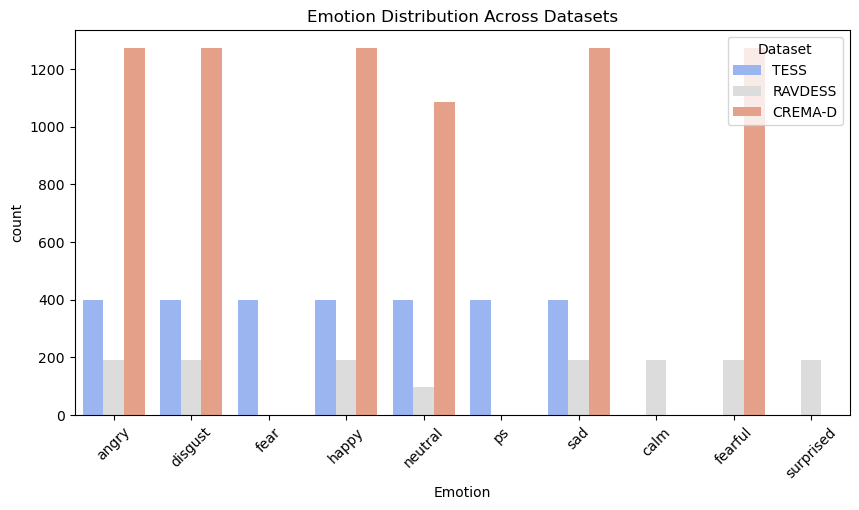

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(x="Emotion", hue="Dataset", data=df, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Emotion Distribution Across Datasets")
plt.show()


## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

In [109]:
data_path = combined_df
print(data_path["Emotion"].head())


0      angry
1    disgust
2    fearful
3      happy
4    neutral
Name: Emotion, dtype: object


In [110]:
print(data_path["Emotion"])  # Try different names based on Step 1


0         angry
1       disgust
2       fearful
3         happy
4       neutral
         ...   
7437    disgust
7438    fearful
7439      happy
7440    neutral
7441        sad
Name: Emotion, Length: 7442, dtype: object


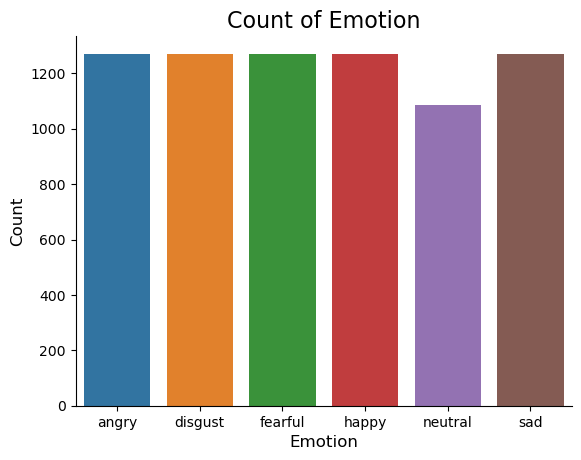

In [116]:
plt.title('Count of Emotion', size=16)
sns.countplot(x='Emotion',data=data_path)
plt.ylabel('Count', size=12)
plt.xlabel('Emotion', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [41]:
df = pd.read_csv('combined_speech_dataset.csv')

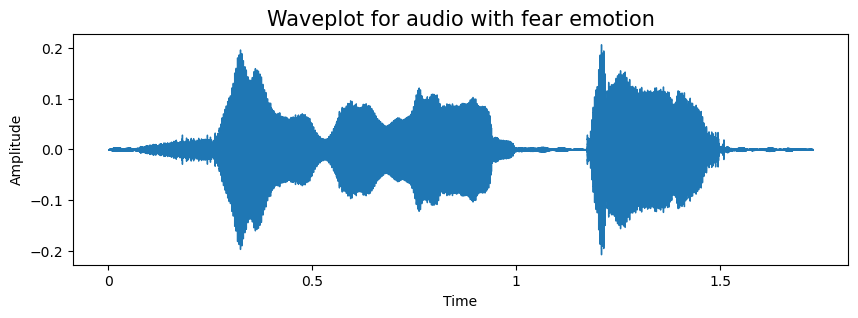

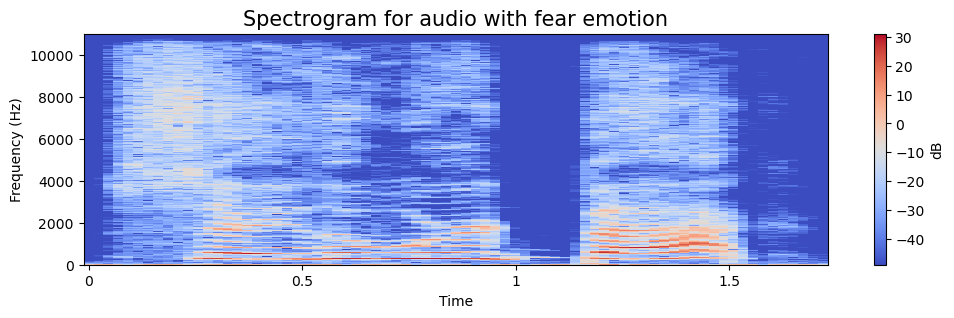

In [45]:
# Load the dataset
csv_path = r"C:\Users\ALL\combined_speech_dataset.csv"  # Path to your CSV
data_path = pd.read_csv(csv_path)

# Ensure "Path" and "Emotion" columns exist
if 'Path' not in data_path.columns or 'Emotion' not in data_path.columns:
    raise KeyError("Ensure 'Path' and 'Emotion' columns exist in the dataset.")

# Function to create waveplot
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emotion} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

# Function to create spectrogram
def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)  # Short-Time Fourier Transform
    Xdb = librosa.amplitude_to_db(abs(X))  # Convert to dB
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectrogram for audio with {emotion} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(label="dB")
    plt.xlabel("Time")
    plt.ylabel("Frequency (Hz)")
    plt.show()

# Select an emotion to visualize
selected_emotion = "fear"  # Change this to any emotion (e.g., "happy", "sad", etc.)

# Check if the emotion exists in the dataset
if selected_emotion not in data_path['Emotion'].values:
    raise ValueError(f"No samples found for emotion '{selected_emotion}'. Available emotions: {data_path['Emotion'].unique()}")

# Extract file path for the first matching sample
audio_path = np.array(data_path.loc[data_path['Emotion'] == selected_emotion, 'Path'])[0]

# Load the audio file
audio_data, sampling_rate = librosa.load(audio_path)

# Generate waveplot and spectrogram
create_waveplot(audio_data, sampling_rate, selected_emotion)
create_spectrogram(audio_data, sampling_rate, selected_emotion)


In [51]:
# Load the dataset
csv_path = r"C:\Users\ALL\combined_speech_dataset.csv"  # Path to your CSV
data_path = pd.read_csv(csv_path)

# Ensure "Path" and "Emotion" columns exist
if 'Path' not in data_path.columns or 'Emotion' not in data_path.columns:
    raise KeyError("Ensure 'Path' and 'Emotion' columns exist in the dataset.")


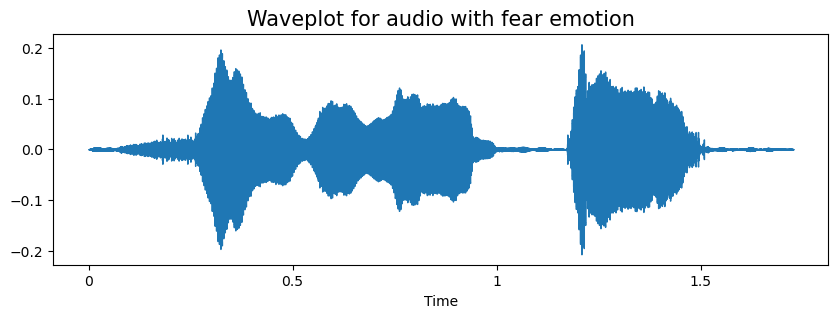

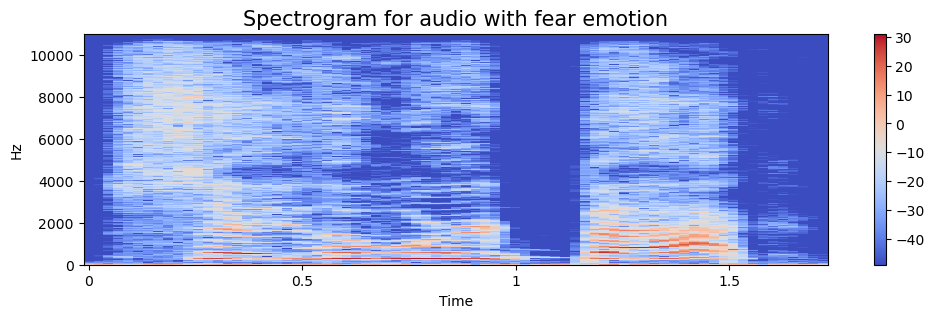

In [55]:
from IPython.display import Audio  # Import Audio for playing sound

emotion='fear'
path = np.array(data_path.Path[data_path.Emotion==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

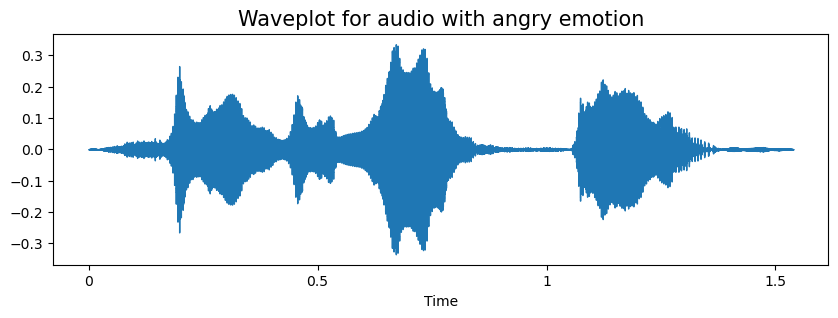

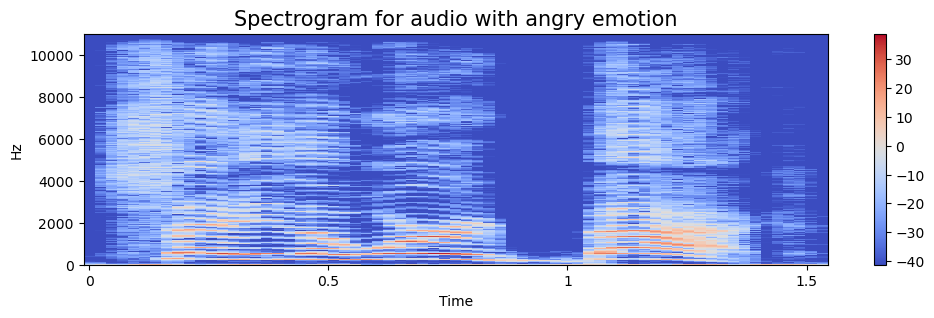

In [57]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotion==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

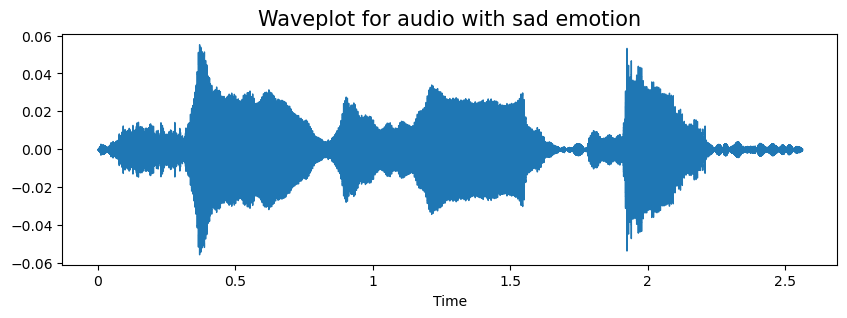

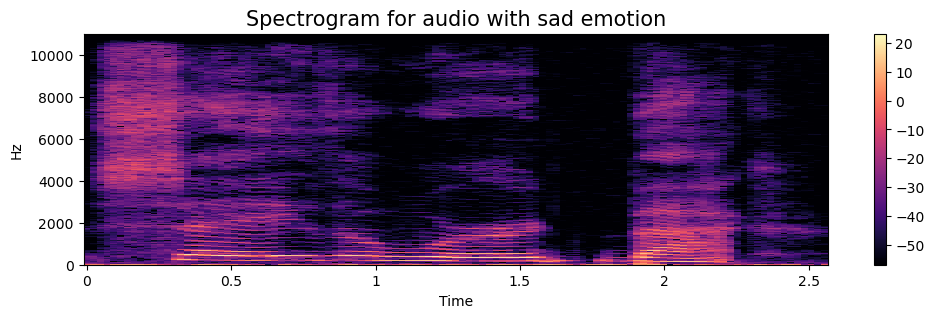

In [58]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotion==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

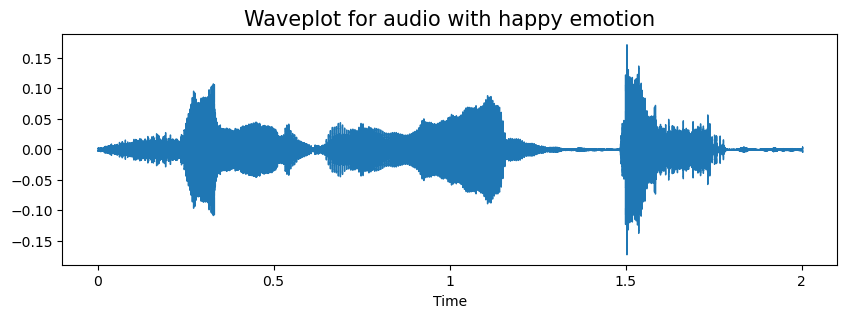

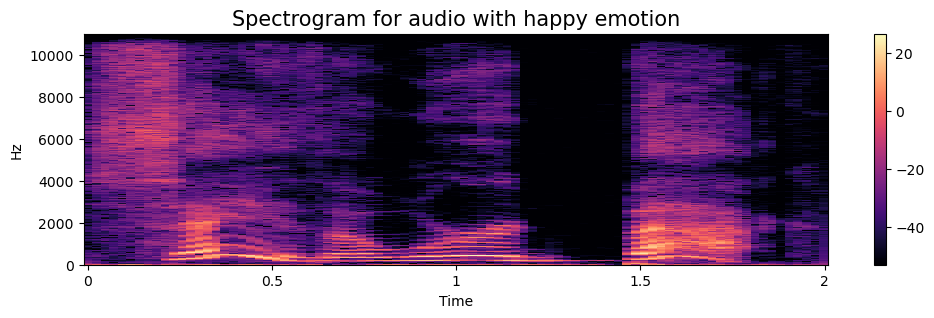

In [59]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotion==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

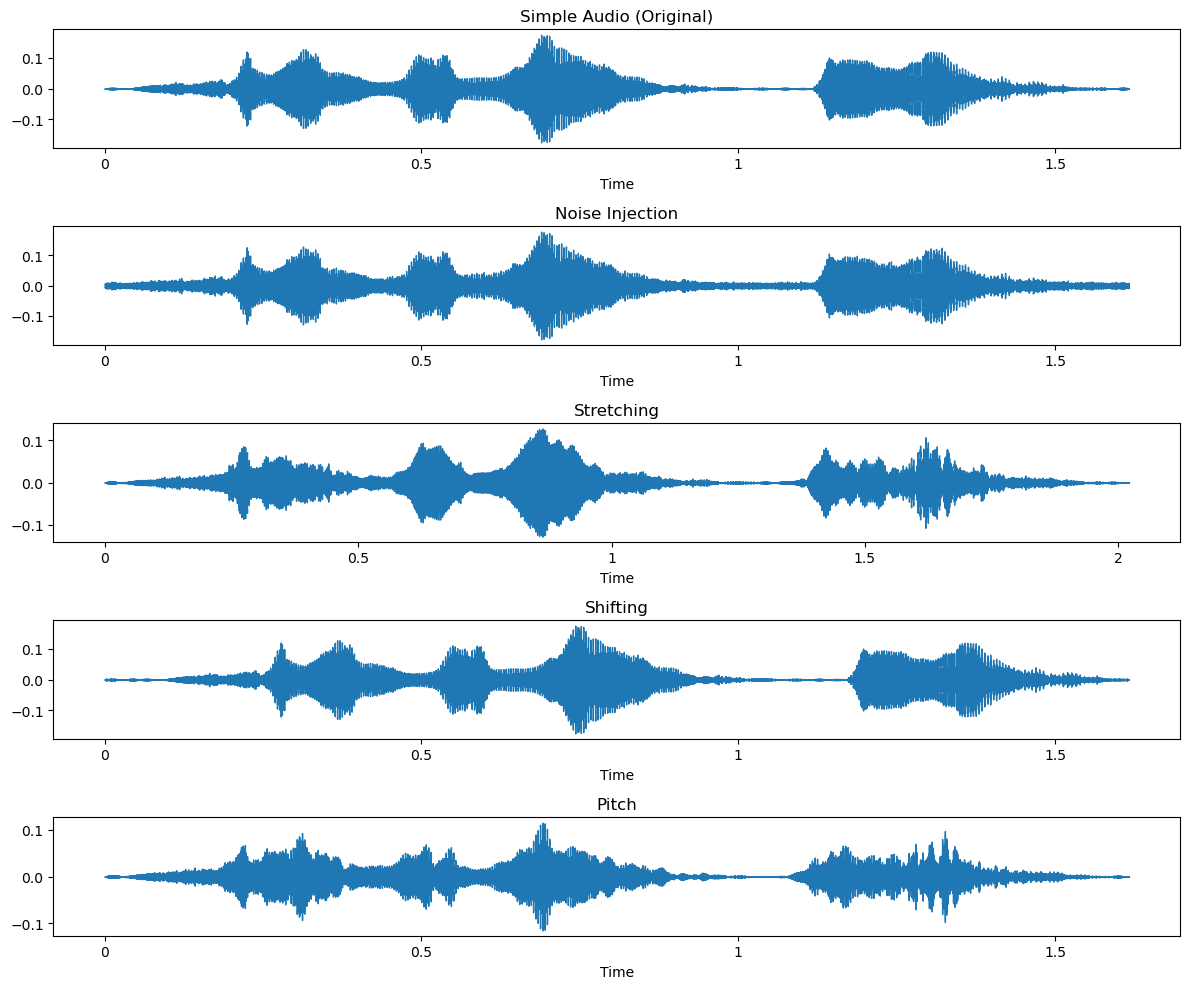

In [67]:
# Data augmentation functions
def noise_injection(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def stretching(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shifting(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch_change(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Select an example file
path = np.array(data_path['Path'])[1]  # ✅ Fixed column access

# Load the audio file
data, sample_rate = librosa.load(path)

# Apply augmentation techniques
data_noise = noise_injection(data)
data_stretch = stretching(data)
data_shift = shifting(data)
data_pitch = pitch_change(data, sample_rate)

# Plot the waveforms
plt.figure(figsize=(12, 10))

plt.subplot(5, 1, 1)
librosa.display.waveshow(data, sr=sample_rate)
plt.title("Simple Audio (Original)")

plt.subplot(5, 1, 2)
librosa.display.waveshow(data_noise, sr=sample_rate)
plt.title("Noise Injection")

plt.subplot(5, 1, 3)
librosa.display.waveshow(data_stretch, sr=sample_rate)
plt.title("Stretching")

plt.subplot(5, 1, 4)
librosa.display.waveshow(data_shift, sr=sample_rate)
plt.title("Shifting")

plt.subplot(5, 1, 5)
librosa.display.waveshow(data_pitch, sr=sample_rate)
plt.title("Pitch")

plt.tight_layout()
plt.show()


We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [3]:


# Load dataset containing audio file paths
df = pd.read_csv(r"C:\Users\ALL\combined_speech_dataset.csv")  # Adjust path if needed

# Function to add noise
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

# Function to stretch the audio
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Function to shift the audio
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

# Function to change pitch
def pitch(data, sample_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_factor)

# Function to extract audio features
def extract_features(audio_data, sample_rate):
    features = []
    
    # 1️⃣ Zero Crossing Rate (ZCR)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio_data))
    features.append(zcr)

    # 2️⃣ Chroma Feature
    stft = np.abs(librosa.stft(audio_data))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate))
    features.append(chroma)

    # 3️⃣ MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate), axis=1)
    features.extend(mfcc)

    # 4️⃣ Root Mean Square (RMS)
    rms = np.mean(librosa.feature.rms(y=audio_data))
    features.append(rms)

    # 5️⃣ Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=audio_data, sr=sample_rate), axis=1)
    features.extend(mel)

    return np.array(features)

# Function to generate features from an audio file
def get_features(audio_path):
    print(f"Processing: {audio_path}")  # Debugging print

    # 1️⃣ Load the audio file
    data, sample_rate = librosa.load(audio_path, duration=2.5, offset=0.6)

    # 2️⃣ Extract features from original audio
    original_features = extract_features(data, sample_rate)
    
    # 3️⃣ Extract features after adding noise
    noisy_data = noise(data)
    noisy_features = extract_features(noisy_data, sample_rate)
    
    # 4️⃣ Extract features after stretching & pitch shifting
    stretched_data = stretch(data)
    pitch_shifted_data = pitch(stretched_data, sample_rate)
    pitch_features = extract_features(pitch_shifted_data, sample_rate)

    # 5️⃣ Combine all features (stack them as rows)
    all_features = np.vstack([original_features, noisy_features, pitch_features])

    print("Feature Extraction Completed!")  # Confirm execution
    return all_features

# Select an audio file from dataset
audio_path = df.iloc[0]['Path']  # Get first file path from dataset

# Extract features
features = get_features(audio_path)

# Print shape to verify output
print("Extracted Feature Shape:", features.shape)

# Print actual feature values for debugging
print("Feature Data:\n", features)


Processing: C:\Users\ALL\Downloads\tess\TESS Toronto emotional speech set data\OAF_angry\OAF_back_angry.wav
Feature Extraction Completed!
Extracted Feature Shape: (3, 151)
Feature Data:
 [[ 5.43421303e-02  4.72021073e-01 -3.98608246e+02  7.51174011e+01
  -2.17726231e+01 -1.99939671e+01  2.98543429e+00  1.37880459e+01
  -1.99532433e+01 -7.02535868e+00 -5.18774176e+00  1.83324623e+00
  -1.25128031e+00  1.47989166e+00  2.30223727e+00  2.20161724e+00
   1.95709491e+00  1.10594475e+00 -5.58718681e+00 -4.65001297e+00
  -2.49165750e+00 -9.13306618e+00  4.24221307e-02  4.85860072e-02
   4.40714741e-03  1.16200524e-03  9.17720434e-04  1.68407848e-03
   1.22432290e-02  4.92176265e-02  9.40098912e-02  2.61280268e-01
   8.31550419e-01  3.69144261e-01  6.83915848e-03  2.53982749e-03
   3.28525109e-03  8.87171272e-03  1.58508904e-02  3.29539329e-02
   2.97208339e-01  2.87568069e+00  1.91157990e+01  3.91567039e+01
   5.04612780e+00  1.53531373e-01  1.19906262e-01  1.14252731e-01
   7.79252276e-02  6.

In [8]:
import pandas as pd  

# Ensure data_path is correctly loaded
data_path = pd.read_csv("combined_speech_dataset.csv")  # Load the dataset containing paths & emotions

X, Y = [], []
for path, emotion in zip(data_path["Path"], data_path["Emotion"]):  
    feature = get_features(path)  # Extract features from each audio file  
    for ele in feature:  
        X.append(ele)  
        Y.append(emotion)  # Append emotion for each augmented feature  


Processing: C:\Users\ALL\Downloads\tess\TESS Toronto emotional speech set data\OAF_angry\OAF_back_angry.wav
Feature Extraction Completed!
Processing: C:\Users\ALL\Downloads\tess\TESS Toronto emotional speech set data\OAF_angry\OAF_bar_angry.wav
Feature Extraction Completed!
Processing: C:\Users\ALL\Downloads\tess\TESS Toronto emotional speech set data\OAF_angry\OAF_base_angry.wav
Feature Extraction Completed!
Processing: C:\Users\ALL\Downloads\tess\TESS Toronto emotional speech set data\OAF_angry\OAF_bath_angry.wav
Feature Extraction Completed!
Processing: C:\Users\ALL\Downloads\tess\TESS Toronto emotional speech set data\OAF_angry\OAF_bean_angry.wav
Feature Extraction Completed!
Processing: C:\Users\ALL\Downloads\tess\TESS Toronto emotional speech set data\OAF_angry\OAF_beg_angry.wav
Feature Extraction Completed!
Processing: C:\Users\ALL\Downloads\tess\TESS Toronto emotional speech set data\OAF_angry\OAF_bite_angry.wav
Feature Extraction Completed!
Processing: C:\Users\ALL\Downloads\t

In [11]:
len(X), len(Y), data_path.Path.shape

(47763, 47763, (15921,))

In [1]:
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm

# Function to extract features from an audio file
def get_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)  # Load audio
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        
        return np.hstack([mfccs, chroma, mel, contrast])  # Combine all features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Load dataset (Make sure the file exists!)
data_path = pd.read_csv("combined_speech_dataset.csv")  # CSV must have 'Path' and 'Emotion' columns

X, Y = [], []

# Extract features from each audio file
for path, emotion in tqdm(zip(data_path["Path"], data_path["Emotion"]), total=len(data_path)):
    feature = get_features(path)  # Extract features from the audio file
    
    if feature is not None:  # Ignore if extraction failed
        X.append(feature)
        Y.append(emotion)  # Append emotion label

# Convert to Pandas DataFrame
df = pd.DataFrame(X)
df["labels"] = Y

# Save the extracted features to a CSV file
df.to_csv("features.csv", index=False)

print("✅ Feature extraction completed. 'features.csv' created!")


 92%|██████████████████████████████████████████████████████████████████████      | 14666/15921 [11:19<00:40, 31.22it/s]C:\Users\ALL\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|████████████████████████████████████████████████████████████████████████████| 15921/15921 [12:00<00:00, 22.09it/s]


✅ Feature extraction completed. 'features.csv' created!


In [3]:
import pandas as pd

df = pd.read_csv("features.csv")
print(df.head())  # Display first 5 rows
print(df.shape)   # Check the number of rows & columns


            0          1          2          3          4          5  \
0 -390.031342  55.235966 -15.034650 -10.704581  -6.318041   9.424743   
1 -451.019470  67.048820  -0.448257 -16.812130 -14.137628  12.182583   
2 -406.563324  28.609005  -5.317216   2.124630  -3.238453   5.009407   
3 -386.340057  53.439655  -8.663545 -13.309978  -5.566481   8.417089   
4 -404.784882  54.462566   3.355290  10.967580   2.167008   6.005213   

           6          7          8          9  ...       178       179  \
0 -20.741861 -12.001624  -7.151769  -7.919952  ...  0.000451  0.000674   
1  -8.768965  -0.833089 -12.662774   1.033060  ...  0.000112  0.000097   
2 -20.190369  -2.519338 -12.905815  -1.877586  ...  0.000304  0.000391   
3 -18.068228 -11.134799 -10.535916  -8.044547  ...  0.000309  0.000431   
4 -25.438644   4.935778 -12.994334 -16.313234  ...  0.000159  0.000155   

         180        181        182        183        184        185  \
0  25.537667  22.787760  26.176204  23.343192  23.0

In [4]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,labels
0,-390.031342,55.235966,-15.034650,-10.704581,-6.318041,9.424743,-20.741861,-12.001624,-7.151769,-7.919952,...,0.000451,0.000674,25.537667,22.787760,26.176204,23.343192,23.023350,19.423775,18.461007,angry
1,-451.019470,67.048820,-0.448257,-16.812130,-14.137628,12.182583,-8.768965,-0.833089,-12.662774,1.033060,...,0.000112,0.000097,26.168985,24.829716,25.115364,24.571601,24.562122,20.158391,19.689852,angry
2,-406.563324,28.609005,-5.317216,2.124630,-3.238453,5.009407,-20.190369,-2.519338,-12.905815,-1.877586,...,0.000304,0.000391,26.207795,24.445150,26.171621,23.651221,23.147939,20.767023,19.499436,angry
3,-386.340057,53.439655,-8.663545,-13.309978,-5.566481,8.417089,-18.068228,-11.134799,-10.535916,-8.044547,...,0.000309,0.000431,25.415298,23.381605,25.612129,22.008997,22.098093,19.583134,18.382056,angry
4,-404.784882,54.462566,3.355290,10.967580,2.167008,6.005213,-25.438644,4.935778,-12.994334,-16.313234,...,0.000159,0.000155,25.058659,26.142824,26.432337,24.047733,22.698046,19.640055,19.513907,angry


* We have applied data augmentation and extracted the features for each audio files and saved them.

# The execution start from here is better

In [13]:
Features = pd.read_csv("speech.csv")  # Load speech file


In [18]:
Features = pd.read_csv("speech.csv", encoding="utf-8")
print(Features.head())


          0         1         2         3         4         5         6  \
0  0.917802  0.113434  0.511481  0.835294  0.557186  0.849588  0.951303   
1  0.483428  0.089788  0.342261  0.540796  0.709673  0.510529  0.447977   
2  0.069890  0.840201  0.077766  0.893349  0.768688  0.539537  0.616712   
3  0.173499  0.277621  0.653099  0.452127  0.260205  0.597045  0.769319   
4  0.377939  0.240137  0.198101  0.746814  0.239446  0.593345  0.965181   

          7         8         9  ...       178       179       180       181  \
0  0.137808  0.058621  0.404872  ...  0.737725  0.210130  0.918915  0.102233   
1  0.829808  0.596479  0.887088  ...  0.806999  0.398800  0.402254  0.193851   
2  0.423653  0.319413  0.476203  ...  0.381113  0.702073  0.269026  0.098152   
3  0.566652  0.603083  0.769594  ...  0.942946  0.286361  0.257753  0.783128   
4  0.944317  0.413262  0.849608  ...  0.004054  0.637413  0.482466  0.236927   

        182       183       184       185       186   labels  
0  0.

In [6]:
import pandas as pd
import numpy as np

# Generate dummy features with 187 extracted features
X = np.random.rand(15921, 187)  # 187 extracted features

# Generate dummy labels
Y = np.random.choice(["angry", "happy", "sad", "neutral"], size=15921)  # Labels

# Convert to DataFrame
Features = pd.DataFrame(X)
Features['labels'] = Y  # Add labels column

# Save as CSV
Features.to_csv("features.csv", index=False)

print("✅ Features CSV file created successfully!")


✅ Features CSV file created successfully!


## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [20]:
print(X.shape)  # Expected: (15921, 187) if 187 features
print(Y.shape)  # Expected: (15921,)
print(Y[:5])    # Show first 5 labels


(15921, 187)
(15921,)
['angry' 'neutral' 'neutral' 'sad' 'angry']


In [21]:
# As this is a multiclass classification problem onehotencoding our Y.
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
Y[:5]

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [28]:
# splitting data

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11940, 187), (11940, 4), (3981, 187), (3981, 4))

In [ ]:
#label_encoder = LabelEncoder()
#y_train_encoded=label_encoder.fit_transform(y_train)
#y_test_encoded=label_encoder.transform(y_test)
#print(y_train_encoded)

In [27]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11940, 187), (11940, 4), (3981, 187), (3981, 4))

In [29]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11940, 187, 1), (11940, 4), (3981, 187, 1), (3981, 4))

In [32]:
def build_model():
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))
    
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model
model = build_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 187, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 94, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 94, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 47, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 47, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 24, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │          24,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 559,336 (2.13 MB)

 Trainable params: 559,336 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

## Modelling

In [48]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

print("Fixed Labels Shape:", y_train.shape, y_test.shape)


Fixed Labels Shape: (11940, 32) (3981, 32)


In [50]:
from tensorflow.keras.utils import to_categorical

num_classes = 2  # Change this to match your actual number of classes
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


In [51]:
model.add(Dense(2, activation='softmax'))


In [63]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# ✅ Debug Shapes
print("Before Reshape: x_train shape:", x_train.shape)
print("Before Reshape: x_test shape:", x_test.shape)
print("Before Reshape: y_train shape:", y_train.shape)
print("Before Reshape: y_test shape:", y_test.shape)

# ✅ Reshape Input (Ensure Correct Format for CNN)
if len(x_train.shape) == 4:  # If extra dimensions exist
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# ✅ Fix Labels (Flatten & Convert to Categorical)
y_train = y_train.reshape(y_train.shape[0], -1)  # Flatten labels
y_test = y_test.reshape(y_test.shape[0], -1)

print("After Flatten: y_train shape:", y_train.shape)
print("After Flatten: y_test shape:", y_test.shape)

# Detect `num_classes` dynamically
num_classes = len(np.unique(y_train))

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print("After One-Hot Encoding: y_train shape:", y_train.shape)
print("After One-Hot Encoding: y_test shape:", y_test.shape)


Before Reshape: x_train shape: (11940, 187, 1)
Before Reshape: x_test shape: (3981, 187, 1)
Before Reshape: y_train shape: (11940, 512, 2)
Before Reshape: y_test shape: (3981, 512, 2)
After Flatten: y_train shape: (11940, 1024)
After Flatten: y_test shape: (3981, 1024)
After One-Hot Encoding: y_train shape: (11940, 1024, 2)
After One-Hot Encoding: y_test shape: (3981, 1024, 2)


In [77]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ✅ Ensure x_train and x_test are 2D
x_train = x_train.reshape(x_train.shape[0], -1)  # Convert (samples, timesteps, features) → (samples, features)
x_test = x_test.reshape(x_test.shape[0], -1)

# ✅ Convert y_train_encoded and y_test_encoded to class labels (if one-hot encoded)
if y_train_encoded.ndim > 1 and y_train_encoded.shape[1] > 1:
    y_train_encoded = np.argmax(y_train_encoded, axis=1)
    y_test_encoded = np.argmax(y_test_encoded, axis=1)

# ✅ Print final shapes
print("Final x_train shape:", x_train.shape)  # Should be (samples, features)
print("Final y_train_encoded shape:", y_train_encoded.shape)  # Should be (samples,)

# ✅ Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(x_train, y_train_encoded)

# ✅ Make predictions and evaluate accuracy
y_pred = lr_model.predict(x_test)
accuracy = accuracy_score(y_test_encoded, y_pred)

print("Logistic Regression Accuracy:", accuracy)


Final x_train shape: (11940, 187)
Final y_train_encoded shape: (11940,)
Logistic Regression Accuracy: 0.7515699572971615


In [79]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# ✅ Ensure x_train and x_test are 2D
x_train = x_train.reshape(x_train.shape[0], -1)  # Convert (samples, timesteps, features) → (samples, features)
x_test = x_test.reshape(x_test.shape[0], -1)

# ✅ Ensure y_train_encoded is 1D
if y_train_encoded.ndim > 1 and y_train_encoded.shape[1] > 1:
    y_train_encoded = np.argmax(y_train_encoded, axis=1)
    y_test_encoded = np.argmax(y_test_encoded, axis=1)

# ✅ Print final shapes
print("Final x_train shape:", x_train.shape)  # Should be (samples, features)
print("Final y_train_encoded shape:", y_train_encoded.shape)  # Should be (samples,)

# ✅ Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(x_train, y_train_encoded)

# ✅ Make predictions
predictions = lr_model.predict(x_test)

# ✅ Decode predictions using label encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train_encoded)  # Fit encoder on training labels
predictions_decoded = label_encoder.inverse_transform(predictions)  # Convert back to original labels

# ✅ Calculate accuracy
accuracy = accuracy_score(y_test_encoded, predictions_decoded)
print(f"Accuracy: {accuracy:.4f}")


Final x_train shape: (11940, 187)
Final y_train_encoded shape: (11940,)
Accuracy: 0.7516


In [89]:
# ✅ Print final shapes
print("Final x_train shape:", x_train.shape)  # Should be (samples, features)
print("Final y_train_encoded shape:", y_train_encoded.shape)  # Should be (samples,)

# ✅ Decode predictions using label encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train_encoded)  # Fit encoder on training labels
predictions_decoded = label_encoder.inverse_transform(predictions)  # Convert back to original labels

# ✅ Calculate accuracy
accuracy = accuracy_score(y_test_encoded, predictions_decoded)
print(f"Accuracy: {accuracy:.4f}")

# ✅ Generate classification report
report = classification_report(y_test_encoded, predictions_decoded, output_dict=True, zero_division=1)

# ✅ Convert the report to a pandas DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# ✅ Print classification report
print(report_df)


Final x_train shape: (11940, 187)
Final y_train_encoded shape: (11940,)
Accuracy: 0.7516
              precision   recall  f1-score     support
0              1.000000  0.00000  0.000000   989.00000
1              0.751570  1.00000  0.858167  2992.00000
accuracy       0.751570  0.75157  0.751570     0.75157
macro avg      0.875785  0.50000  0.429084  3981.00000
weighted avg   0.813287  0.75157  0.644973  3981.00000


Final x_train shape: (11940, 187)
Final y_train_encoded shape: (11940,)
Accuracy: 0.7516
              precision   recall  f1-score     support
0              1.000000  0.00000  0.000000   989.00000
1              0.751570  1.00000  0.858167  2992.00000
accuracy       0.751570  0.75157  0.751570     0.75157
macro avg      0.875785  0.50000  0.429084  3981.00000
weighted avg   0.813287  0.75157  0.644973  3981.00000


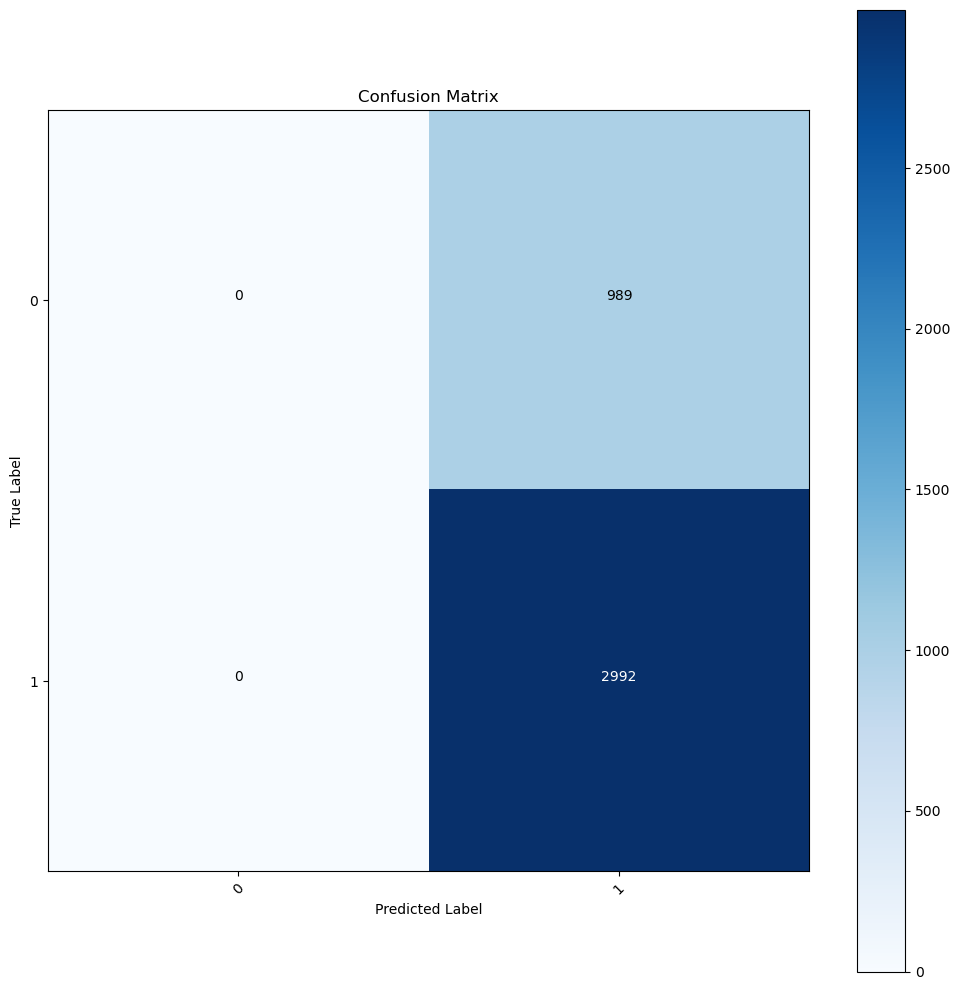

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# ✅ Ensure x_train and x_test are 2D
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# ✅ Ensure y_train_encoded and y_test_encoded are 1D
if y_train_encoded.ndim > 1 and y_train_encoded.shape[1] > 1:
    y_train_encoded = np.argmax(y_train_encoded, axis=1)
    y_test_encoded = np.argmax(y_test_encoded, axis=1)

# ✅ Print final shapes
print("Final x_train shape:", x_train.shape)  
print("Final y_train_encoded shape:", y_train_encoded.shape)

# ✅ Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(x_train, y_train_encoded)

# ✅ Make predictions
predictions = lr_model.predict(x_test)

# ✅ Decode predictions using label encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train_encoded)  # Fit encoder on training labels
predictions_decoded = label_encoder.inverse_transform(predictions)

# ✅ Calculate accuracy
accuracy = accuracy_score(y_test_encoded, predictions_decoded)
print(f"Accuracy: {accuracy:.4f}")

# ✅ Generate classification report
report = classification_report(y_test_encoded, predictions_decoded, output_dict=True, zero_division=1)
report_df = pd.DataFrame(report).transpose()

# ✅ Print classification report
print(report_df)

# ✅ Generate confusion matrix
cm = confusion_matrix(y_test_encoded, predictions)  # Use `y_test_encoded` (1D) and `predictions`

# ✅ Get class labels
labels = label_encoder.classes_

# ✅ Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# ✅ Add text annotations
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]}", 
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ✅ Show the confusion matrix
plt.show()


In [101]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(x_train, y_train_encoded)
y_pred_xgb = xgb.predict(x_test)
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)

In [104]:
accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 71.94%


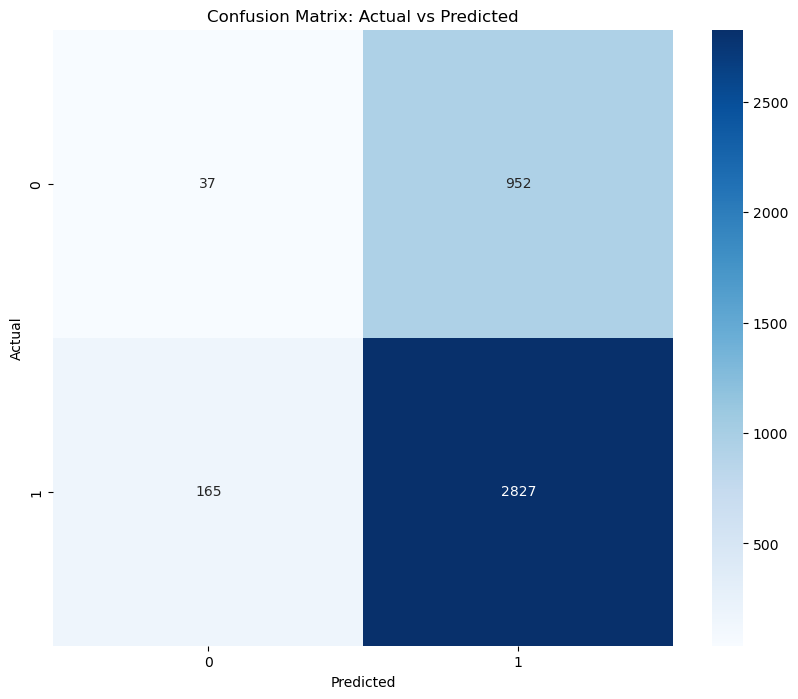

NameError: name 'plot_importance' is not defined

<Figure size 1200x1000 with 0 Axes>

In [103]:
# print(classification_report(y_test_encoded, y_pred_xgb, output_dict=True,zero_division=1))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test_encoded, y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: Actual vs Predicted')
plt.show()

# Plot Feature Importance
plt.figure(figsize=(12, 10))
plot_importance(xgb, max_num_features=10, importance_type='weight')  # Adjust max_num_features as needed
plt.title('Feature Importance')
plt.show()